In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [9]:
# MNIST
train_mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_mnist = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Fashion-MNIST
train_fmnist = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_fmnist = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)


In [10]:
# Define split ratio
val_ratio = 0.1

mnist_train_size = int((1 - val_ratio) * len(train_mnist))
mnist_val_size = len(train_mnist) - mnist_train_size
train_mnist, val_mnist = random_split(train_mnist, [mnist_train_size, mnist_val_size])

fmnist_train_size = int((1 - val_ratio) * len(train_fmnist))
fmnist_val_size = len(train_fmnist) - fmnist_train_size
train_fmnist, val_fmnist = random_split(train_fmnist, [fmnist_train_size, fmnist_val_size])


In [11]:
batch_size = 64

train_loader_mnist = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)
test_loader_mnist = DataLoader(test_mnist, batch_size=batch_size, shuffle=False)
val_loader_mnist = DataLoader(val_mnist,batch_size=batch_size, shuffle=False)

train_loader_fmnist = DataLoader(train_fmnist, batch_size=batch_size, shuffle=True)
test_loader_fmnist = DataLoader(test_fmnist, batch_size=batch_size, shuffle=False)
val_loader_fmnist = DataLoader(val_fmnist,batch_size=batch_size, shuffle=False)


In [64]:
images, labels = next(iter(train_loader_mnist))
print("Batch shape:", images.shape)
print("Labels:", labels[:10])


Batch shape: torch.Size([64, 1, 28, 28])
Labels: tensor([4, 1, 7, 8, 4, 3, 2, 1, 4, 6])


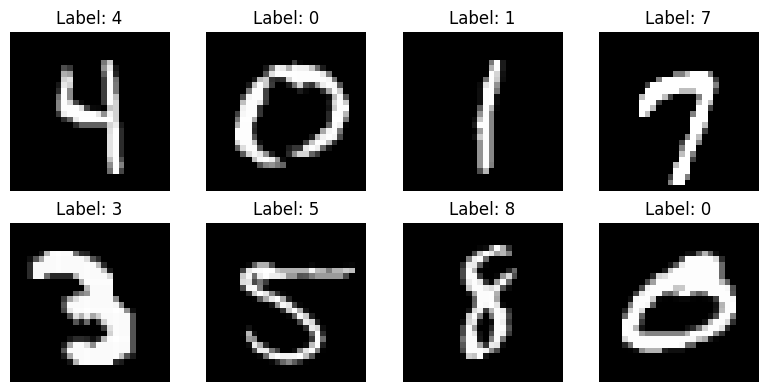

In [65]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(train_loader_mnist))

images = images * 0.5 + 0.5

fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [66]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
        self.relu = nn.ReLU()

    def forward(self, x, return_embedding=False):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        embedding = x
        x = self.relu(x)
        x = self.fc3(x)
        if return_embedding:
            return embedding
        else:
            return x


In [67]:
model = MLP()

images, labels = next(iter(train_loader_mnist))
print("Input shape:", images.shape)

out = model(images)
print("Output shape:", out.shape)


Input shape: torch.Size([64, 1, 28, 28])
Output shape: torch.Size([64, 10])


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


In [69]:
num_epochs = 30

for epoch in range(num_epochs):
    # ---- TRAINING PHASE ----
    model.train()
    running_loss = 0.0

    for images, labels in train_loader_mnist:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader_mnist)

    # ---- VALIDATION PHASE ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader_mnist:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader_mnist)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch [1/30] | Train Loss: 0.5702 | Val Loss: 0.3451
Epoch [2/30] | Train Loss: 0.3030 | Val Loss: 0.2768
Epoch [3/30] | Train Loss: 0.2561 | Val Loss: 0.2537
Epoch [4/30] | Train Loss: 0.2248 | Val Loss: 0.2341
Epoch [5/30] | Train Loss: 0.2023 | Val Loss: 0.2049
Epoch [6/30] | Train Loss: 0.1876 | Val Loss: 0.2057
Epoch [7/30] | Train Loss: 0.1749 | Val Loss: 0.1926
Epoch [8/30] | Train Loss: 0.1632 | Val Loss: 0.1779
Epoch [9/30] | Train Loss: 0.1538 | Val Loss: 0.1696


KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader

model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for images, labs in test_loader_mnist:
        images = images.to(device)
        emb = model(images, return_embedding=True)
        embeddings.append(emb.cpu())
        labels.append(labs)

embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(embeddings)


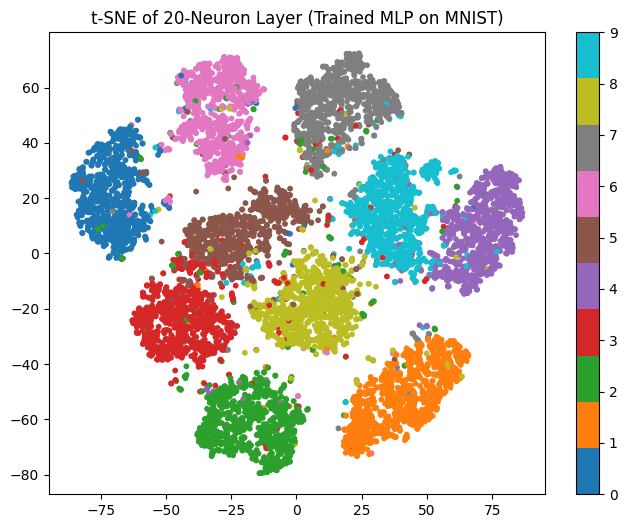

In [ ]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE of 20-Neuron Layer (Trained MLP on MNIST)")
plt.show()


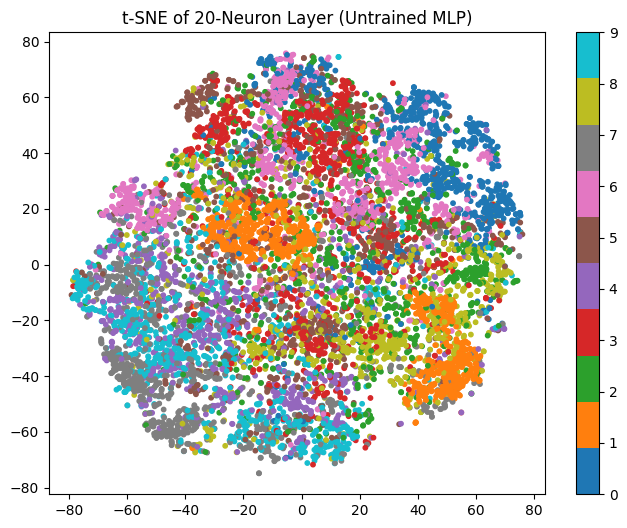

In [ ]:
untrained_model = MLP().to(device)

untrained_emb = []
labels = []

with torch.no_grad():
    for images, labs in test_loader_mnist:
        images = images.to(device)
        emb = untrained_model(images, return_embedding=True)
        untrained_emb.append(emb.cpu())
        labels.append(labs)

untrained_emb = torch.cat(untrained_emb).numpy()
labels = torch.cat(labels).numpy()

emb_2d_untrained = TSNE(n_components=2, random_state=42).fit_transform(untrained_emb)

plt.figure(figsize=(8,6))
scatter = plt.scatter(emb_2d_untrained[:,0], emb_2d_untrained[:,1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE of 20-Neuron Layer (Untrained MLP)")
plt.show()


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
cm = confusion_matrix(y_true, y_pred)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:\n", cm)



Test Accuracy: 0.9534
F1-score: 0.9528
Confusion Matrix:
 [[ 971    0    0    0    1    1    2    1    4    0]
 [   0 1119    4    0    0    0    4    3    5    0]
 [  11    1  977    8    5    6    6   10    7    1]
 [   0    2   16  920    1   35    2   15   13    6]
 [   1    1    6    0  946    2    3    3    2   18]
 [   7    2    6    9    2  833   13    1   14    5]
 [  10    4    2    1    4    6  928    0    3    0]
 [   2    6    9    4    2    3    0  979    4   19]
 [   7    4    2   10    4    9    7    8  917    6]
 [   8    3    1    6   21    5    1   12    8  944]]


In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Flatten and normalize to [0,1]
X_train = train_data.data.view(-1, 28*28).numpy() / 255.0
y_train = train_data.targets.numpy()

X_test = test_data.data.view(-1, 28*28).numpy() / 255.0
y_test = test_data.targets.numpy()

print(X_train.shape, y_train.shape)


(60000, 784) (60000,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
cm_lr = confusion_matrix(y_test, y_pred_lr)

print(f"Logistic Regression → Accuracy: {acc_lr:.4f}, F1: {f1_lr:.4f}")
print(cm_lr)


Logistic Regression → Accuracy: 0.9264, F1: 0.9253
[[ 958    0    1    3    1    9    4    3    1    0]
 [   0 1111    5    2    0    2    3    1   11    0]
 [   6    9  931   16   10    3   12    9   32    4]
 [   4    1   17  924    1   24    2   10   20    7]
 [   1    3    8    3  922    0    5    5    6   29]
 [   9    2    3   35    9  778   15    6   31    4]
 [   8    3    8    2    7   16  911    2    1    0]
 [   1    7   23    7    6    1    0  948    3   32]
 [   9   11    6   21    8   29   14    9  855   12]
 [   9    7    1    9   21    7    0   21    8  926]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)  # Use subset for speed

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Random Forest → Accuracy: {acc_rf:.4f}, F1: {f1_rf:.4f}")
print(cm_rf)


Random Forest → Accuracy: 0.9695, F1: 0.9693
[[ 969    0    0    0    0    3    4    1    3    0]
 [   0 1123    3    3    0    1    4    0    1    0]
 [   6    0  999    6    3    0    4    8    6    0]
 [   1    0    9  973    0    8    0    9    8    2]
 [   1    0    1    0  957    0    6    0    2   15]
 [   3    0    1   12    2  857    6    2    7    2]
 [   5    3    0    0    3    2  941    0    4    0]
 [   1    3   18    4    1    0    0  991    1    9]
 [   2    0    4   10    5    5    6    4  929    9]
 [   8    5    3   10   12    2    1    6    6  956]]


###  Confusion Matrix Observations and Misclassifications
  
**Misclassifications:** The models seems to be confused while predicting 3 with 5. They also face a problem with 9 and 4. There are no other significant misclassifications or cluster overlappings.


**Verdict:**
- **RF > NN > LR**.  
- In terms of F1 score as well test accuracy.


In [ ]:
test_loader_fmnist


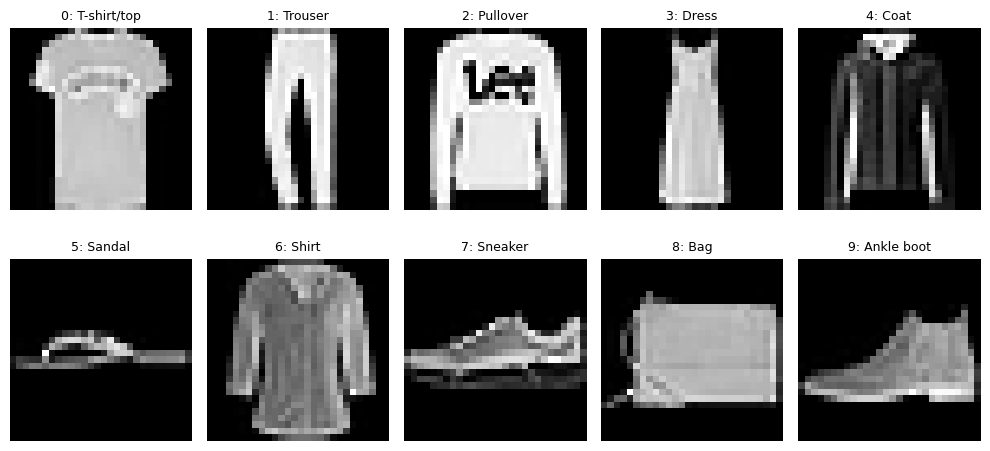

In [ ]:
import matplotlib.pyplot as plt

# Class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Take all test images and labels
all_images, all_labels = next(iter(test_loader_fmnist))

# For each class (0–9), find the first image of that class
examples = []
for class_idx in range(10):
    idx = (all_labels == class_idx).nonzero(as_tuple=True)[0][0]
    examples.append(all_images[idx])

# Denormalize
examples = [img * 0.5 + 0.5 for img in examples]

# Plot one sample per class
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(examples[i].squeeze(), cmap='gray')
    ax.set_title(f"{i}: {class_names[i]}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader_fmnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

acc_fmnist = accuracy_score(y_true, y_pred)
f1_fmnist = f1_score(y_true, y_pred, average='macro')
cm_fmnist = confusion_matrix(y_true, y_pred)

print(f"Cross-domain Test (MNIST-trained model on Fashion-MNIST):")
print(f"Accuracy: {acc_fmnist:.4f}, F1-score: {f1_fmnist:.4f}")
print("Confusion Matrix:\n", cm_fmnist)


Cross-domain Test (MNIST-trained model on Fashion-MNIST):
Accuracy: 0.0962, F1-score: 0.0723
Confusion Matrix:
 [[ 17   5  26 594   2  59   2  11 264  20]
 [ 33   1 186 719   0   2   0   2  52   5]
 [ 56   0  51 187   6 101  46   2 540  11]
 [ 19   4 188 486   2  18   3   2 261  17]
 [ 25   1  52 269   7  36  11   2 595   2]
 [132   5 437  30  61 173  71  76   6   9]
 [ 58   0  25 346   7  90   9   7 445  13]
 [ 10   0 756   2  58  25  69  76   2   2]
 [142   0 246  43  23 248  91  60 142   5]
 [  0   0 653 229   1  88   5   3  21   0]]


In [ ]:
embeddings_fmnist = []
labels_fmnist = []

with torch.no_grad():
    for images, labs in test_loader_fmnist:
        images = images.to(device)
        emb = model(images, return_embedding=True)
        embeddings_fmnist.append(emb.cpu())
        labels_fmnist.append(labs)

embeddings_fmnist = torch.cat(embeddings_fmnist).numpy()
labels_fmnist = torch.cat(labels_fmnist).numpy()


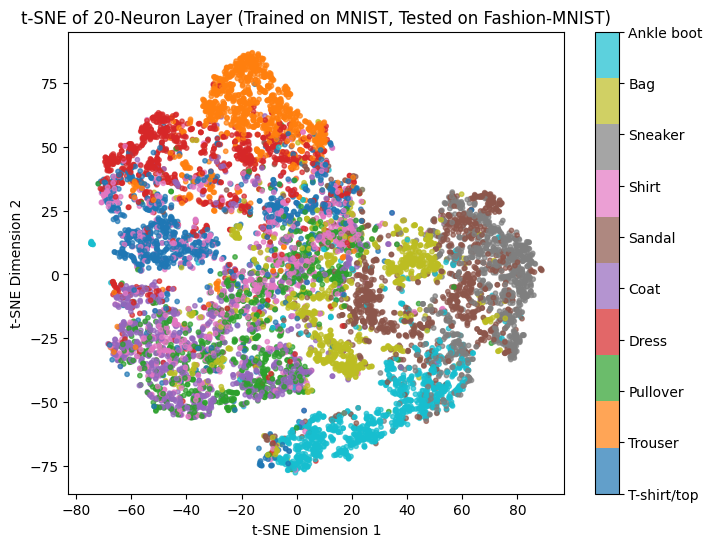

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Fashion-MNIST class names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d_fmnist = tsne.fit_transform(embeddings_fmnist)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    emb_2d_fmnist[:, 0],
    emb_2d_fmnist[:, 1],
    c=labels_fmnist,
    cmap='tab10',
    s=10,
    alpha=0.7
)

# Colorbar with class names
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.ax.set_yticklabels(class_names)

plt.title("t-SNE of 20-Neuron Layer (Trained on MNIST, Tested on Fashion-MNIST)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


###  Testing FMNIST on MNIST trained Model
  
The model performance is very bad because of no correlation of classes between the two datasets.Class 1 does get predicted quite nicely because of its similiarites with the number 1.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model_cnn.train()
    running_loss = 0.0
    for images, labels in train_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_mnist):.4f}")


Epoch [1/10], Loss: 0.2251
Epoch [2/10], Loss: 0.0753
Epoch [3/10], Loss: 0.0530
Epoch [4/10], Loss: 0.0401
Epoch [5/10], Loss: 0.0300
Epoch [6/10], Loss: 0.0241
Epoch [7/10], Loss: 0.0188
Epoch [8/10], Loss: 0.0147
Epoch [9/10], Loss: 0.0125
Epoch [10/10], Loss: 0.0108


In [ ]:
model_cnn.eval()
y_true, y_pred = [], []

start_time = time.time()
with torch.no_grad():
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
end_time = time.time()

acc_cnn = accuracy_score(y_true, y_pred)
f1_cnn = f1_score(y_true, y_pred, average='macro')
cm_cnn = confusion_matrix(y_true, y_pred)
inference_time_cnn = end_time - start_time

print(f"\nSimple CNN — Accuracy: {acc_cnn:.4f}, F1: {f1_cnn:.4f}, Inference time: {inference_time_cnn:.2f}s")



Simple CNN — Accuracy: 0.9856, F1: 0.9854, Inference time: 1.54s


In [26]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# ✅ Use your existing transform (for pretrained models)
transform_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ✅ Load the full MNIST dataset (train + test combined)
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_pretrained)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_pretrained)

# Combine them for more data if desired:
from torch.utils.data import ConcatDataset
combined_dataset = ConcatDataset([full_dataset, test_dataset])

# ✅ Split into Train (80%), Val (10%), Test (10%)
total_len = len(combined_dataset)
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

train_data, val_data, test_data = random_split(combined_dataset, [train_size, val_size, test_size])

# ✅ Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")


Train: 56000 | Val: 7000 | Test: 7000


In [13]:
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1').to(device)
efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1').to(device)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- 1️⃣ Load Pretrained Models ---
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')
efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')

# --- 2️⃣ Freeze Feature Extractor ---
for param in mobilenet.features.parameters():
    param.requires_grad = False

for param in efficientnet.features.parameters():
    param.requires_grad = False

# --- 3️⃣ Modify Classifier (Add Hidden Layer) ---
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(mobilenet.last_channel, 256),  # hidden layer
    nn.ReLU(),
    nn.Linear(256, 10)  # 10 output classes
)

efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(efficientnet.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

mobilenet, efficientnet = mobilenet.to(device), efficientnet.to(device)

# --- 4️⃣ Define Loss & Optimizers ---
criterion = nn.CrossEntropyLoss()
optimizer_m = optim.Adam(mobilenet.classifier.parameters(), lr=1e-3)
optimizer_e = optim.Adam(efficientnet.classifier.parameters(), lr=1e-3)

# --- 5️⃣ Training Loop Example (for MobileNet) ---
def train_model(model, optimizer, train_loader, val_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")



Using device: cuda


In [28]:
train_model(mobilenet, optimizer_m, train_loader, val_loader, num_epochs=5)

Epoch [1/5] | Train Loss: 0.3033 | Val Loss: 0.2150 | Val Acc: 0.9323
Epoch [2/5] | Train Loss: 0.1870 | Val Loss: 0.1365 | Val Acc: 0.9550
Epoch [3/5] | Train Loss: 0.1669 | Val Loss: 0.1225 | Val Acc: 0.9601
Epoch [4/5] | Train Loss: 0.1471 | Val Loss: 0.1149 | Val Acc: 0.9641
Epoch [5/5] | Train Loss: 0.1328 | Val Loss: 0.1080 | Val Acc: 0.9653


In [27]:
train_model(efficientnet, optimizer_e, train_loader, val_loader, num_epochs=5)


Epoch [1/5] | Train Loss: 0.5638 | Val Loss: 0.1570 | Val Acc: 0.9491
Epoch [2/5] | Train Loss: 0.2381 | Val Loss: 0.1301 | Val Acc: 0.9591
Epoch [3/5] | Train Loss: 0.2077 | Val Loss: 0.1095 | Val Acc: 0.9660
Epoch [4/5] | Train Loss: 0.1863 | Val Loss: 0.1027 | Val Acc: 0.9684
Epoch [5/5] | Train Loss: 0.1762 | Val Loss: 0.1008 | Val Acc: 0.9693


In [37]:
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds, all_labels = [],[]
    start_time = time.time()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_image = total_time / len(val_loader.dataset)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\nAccuracy       : {acc:.4f}")
    print(f"F1-score       : {f1:.4f}")
    print(f"Inference time : {total_time:.2f}s total ({avg_time_per_image*1000:.4f} ms/image)")
    print("\nConfusion Matrix:")
    print(cm)

    return acc, f1, cm, total_time


In [38]:
print("MobileNet Evaluation")
acc_m, f1_m, cm_m,tt_m = evaluate_model(mobilenet, test_loader, device)

print("\nEfficientNet Evaluation")
acc_e, f1_e, cm_e,tt_e = evaluate_model(efficientnet, test_loader, device)


MobileNet Evaluation

Accuracy       : 0.9669
F1-score       : 0.9668
Inference time : 16.16s total (2.3086 ms/image)

Confusion Matrix:
[[633   1   1   1   1   3  10   0   2   4]
 [  0 808   2   0   2   0   2   0   0   1]
 [  2   2 676   9   1   4   3   1   6   7]
 [  0   0   4 703   0  13   0   2   2   5]
 [  0   0   3   0 648   0   1   1   0   4]
 [  0   1   8  17   0 613   3   1   4   2]
 [  1   1   1   0   0   1 669   0   4   0]
 [  0   7  11   4   9   2   1 677   2  12]
 [  1   0   2   2   4   2   3   0 649   9]
 [  1   1   1   1   5   3   1   0   4 692]]

EfficientNet Evaluation

Accuracy       : 0.9656
F1-score       : 0.9656
Inference time : 17.89s total (2.5555 ms/image)

Confusion Matrix:
[[644   1   1   0   0   2   4   0   1   3]
 [  0 807   2   0   3   0   0   2   0   1]
 [  2   2 686   4   1   1   3   5   2   5]
 [  1   0   4 700   0  13   0   5   1   5]
 [  0   0   1   0 643   0   0   1   1  11]
 [  0   0   3  17   0 620   3   3   2   1]
 [  4   2   8   0   6   6 649   0

##  Model Performance Comparison

| Model            | Accuracy | F1-Score | Inference Time (s) | Verdict |
|------------------|-----------|-----------|--------------------|----------|
| **Vanilla CNN**  | 0.9856    | 0.9854    | 1.54               | Fastest due to lack of parameters |
| **MobileNet**    | 0.9656    | 0.9656    | 16.16              | too complex for such complex model returns not as good as time taken |
| **EfficientNet** | 0.9856    | 0.9668    | 17.89              | Slowest amongst all |

